In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import os.path

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [53]:
# baseline = None
#resfile = os.path.join(helpers.resultsdir, 'meg_singledot_201706121047.h5')

# baseline = (-0.3, 0)
resfile = os.path.join(helpers.resultsdir, 'meg_singledot_201706131051.h5')

# source GLM, baseline (-0.3, 0), no permutations
#resfile = os.path.join(helpers.resultsdir, 'source_singledot_201706161257.h5')

# source GLM, baseline (-0.3, 0), only basic regressors
#resfile = os.path.join(helpers.resultsdir, 'source_singledot_201706221206.h5')

# label mode = mean, baseline (-0.3, 0), dots 3-5, 
# source GLM, sum_dot_y_prev_3, accev_3, dot_x, dot_y, trial regressors
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
#resfile = os.path.join(helpers.resultsdir, 'source_singledot_201709071126.h5')

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [54]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax', ax=None):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names, ax=ax);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names, ax=ax);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names, ax=ax)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names, ax=ax)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)
            
def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    
def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

In [55]:
second_level = pd.read_hdf(resfile, 'second_level')

with open('/proc/meminfo') as memfile:
    freemem = -1
    while freemem < 0:
        line = memfile.readline()
        if line.startswith('MemAvailable:'):
            freemem = int(line.split()[1])

# if there is at least 3.5 GB of RAM available
if freemem > 2500000:
    first_level = pd.read_hdf(resfile, 'first_level')

perms = second_level.index.levels[0]

dots = pd.read_hdf(resfile, 'dots')
#dots = np.arange(3, 6)

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
#tvals = (second_level.xs('mean', axis=1, level='measure')  / 
#         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))

### describe genuine regressors

In [8]:
measure = 'tval'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,accev_3,dot_x_3,dot_x_4,dot_x_5,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,sum_dot_y_prev_3,trial_time
count,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000
mean,0.002682,-0.011900,0.000541,-0.024851,-0.019567,0.011749,-0.007289,0.009762,-0.049499,0.007276,0.013910,0.002569
std,1.431060,1.215529,1.251120,1.245812,1.106756,1.077350,1.079217,1.070880,1.199931,1.130691,1.121859,1.051270
min,-6.147885,-6.866178,-6.192356,-5.920868,-6.049638,-5.104697,-5.980872,-4.605563,-5.827548,-5.753628,-5.392324,-4.188391
25%,-0.894414,-0.808839,-0.813053,-0.795586,-0.727755,-0.690184,-0.717629,-0.698504,-0.795130,-0.732851,-0.739025,-0.709682
50%,0.008925,-0.008387,-0.007753,-0.040237,-0.006220,0.020553,-0.005288,0.014626,-0.039074,0.008215,0.014551,-0.021322
75%,0.909549,0.775878,0.806881,0.740704,0.695476,0.724689,0.697727,0.714402,0.712274,0.739168,0.770407,0.690248
max,6.677492,6.304245,6.380068,6.974560,5.165764,4.953857,5.116633,4.994499,4.973247,5.316935,5.773073,4.641442


### describe regressors of first permutation

In [9]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,accev_3,dot_x_3,dot_x_4,dot_x_5,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,sum_dot_y_prev_3,trial_time
count,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000
mean,-0.002393,0.001351,-0.008212,0.001251,-0.000008,0.003748,0.005604,-0.003728,-0.074114,0.000216,0.003009,0.005567
std,1.039073,1.057288,1.040432,1.033273,1.034091,1.026488,1.036389,1.030872,1.468402,1.041460,1.037867,1.048711
min,-4.979075,-5.275210,-4.590131,-4.586868,-6.029780,-5.146145,-4.355310,-4.710567,-6.546745,-4.477973,-5.019478,-5.323227
25%,-0.693916,-0.704299,-0.694675,-0.685787,-0.672803,-0.680654,-0.688356,-0.685374,-1.069770,-0.685753,-0.686748,-0.692563
50%,-0.006671,-0.003325,-0.007097,0.001630,0.002113,-0.000957,0.010399,0.004869,-0.096444,0.001251,0.001867,0.001788
75%,0.680240,0.701389,0.675463,0.688313,0.676127,0.688881,0.694021,0.685092,0.879592,0.689372,0.691182,0.696761
max,4.115688,5.541952,4.663039,4.494968,5.024081,4.551581,4.193515,5.803642,5.740134,4.612884,4.162590,5.305300


## Show evolution of max (across channels) through the trial

<IPython.core.display.Javascript object>


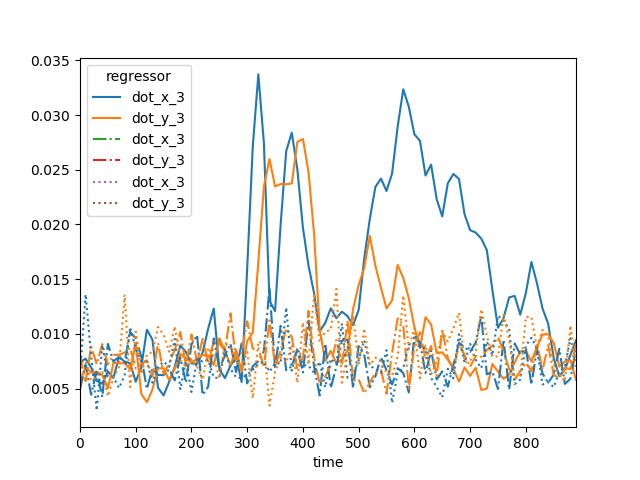

In [60]:
reg = ['dot_x_3', 'dot_y_3']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

<IPython.core.display.Javascript object>


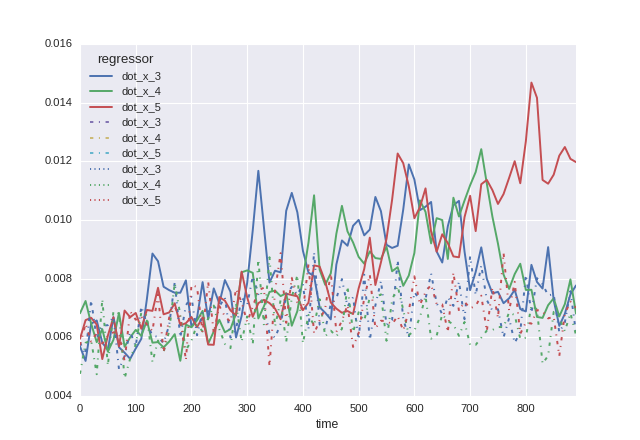

In [32]:
reg = ['dot_x_3', 'dot_x_4', 'dot_x_5']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

trial-wise regressors

<IPython.core.display.Javascript object>


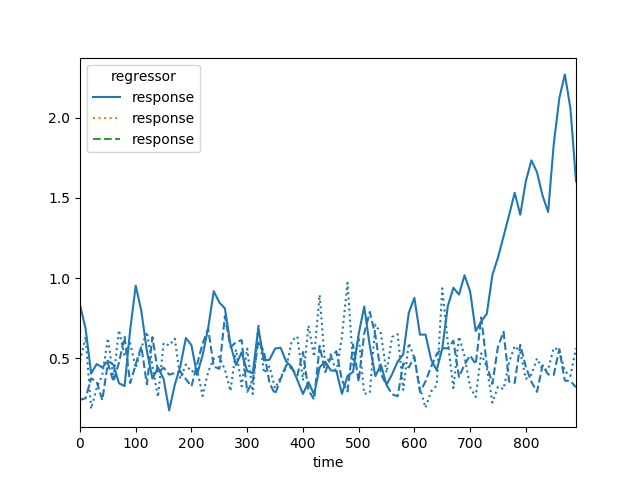

In [63]:
reg = ['response']
measure = 'mlog10p'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

In [71]:
reg = 'dot_x_3'
chalab = second_level.index.names[1]
labels = second_level.xs(0, level='permnr').abs().mean(level=chalab)[(measure, reg)].sort_values(ascending=False)
labels.iloc[:20]

channel
MEG2121    2.576584
MEG1831    2.535562
MEG0741    2.504511
MEG1931    2.463030
MEG0731    2.416652
MEG2241    2.386251
MEG0711    2.167035
MEG1821    2.157792
MEG2331    2.114765
MEG2011    2.056520
MEG2141    2.028197
MEG0721    1.986779
MEG2111    1.937624
MEG2131    1.933826
MEG0431    1.885980
MEG2021    1.885281
MEG1741    1.848719
MEG1731    1.788225
MEG2211    1.763899
MEG0631    1.675944
Name: (mlog10p, dot_x_3), dtype: float64

<IPython.core.display.Javascript object>


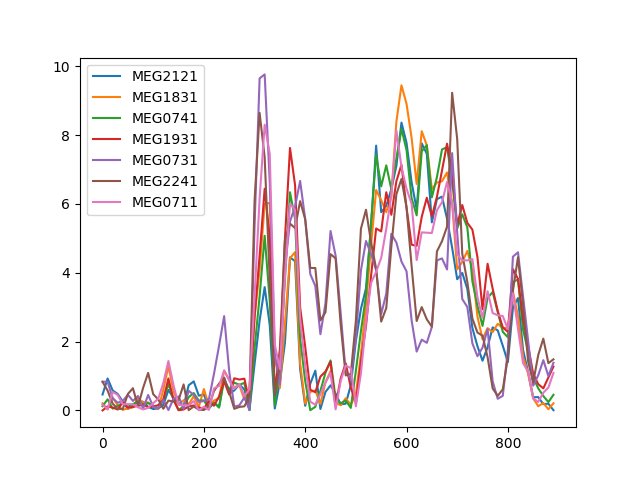

In [72]:
Ntop = 7
fig, ax = plt.subplots()
ax.plot(second_level.index.levels[2], 
        second_level.loc[(0, labels.iloc[:Ntop].index, slice(None)), (measure, reg)]
        .reset_index(level=chalab).pivot(columns=chalab))
ax.legend(labels.iloc[:Ntop].index);

## Dot-specific effects in single channel / label

<IPython.core.display.Javascript object>


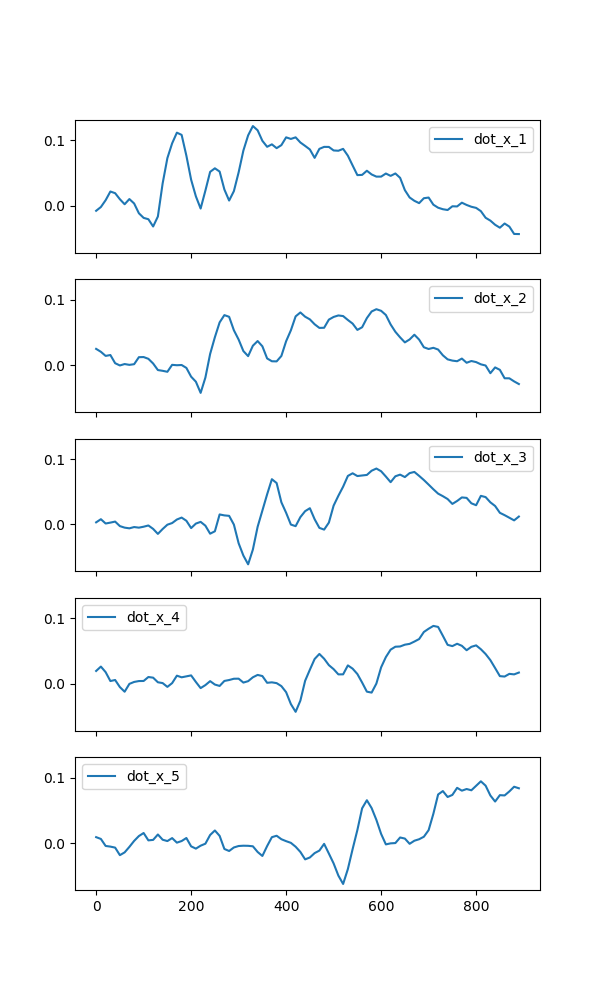

In [101]:
r_name = 'dot_x'
regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

measure = 'mean'
label = 'MEG0741'

fig, axes = plt.subplots(R, 1, sharex=True, sharey=True, figsize=[6, 10])

times = second_level.index.levels[2]
for r, reg in enumerate(regs):
    axes[r].plot(times, second_level.loc[(0, label, slice(None)), (measure, reg)])
    axes[r].legend([reg])

<IPython.core.display.Javascript object>


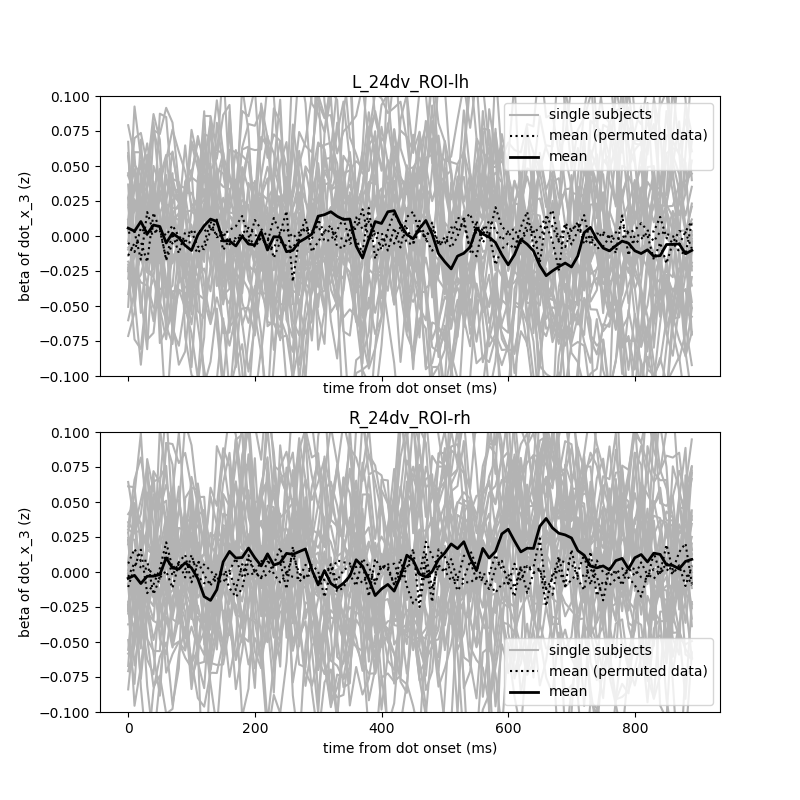

In [51]:
r_name = 'dot_x_3'
area = '24dv'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

In [43]:
time = slice(800, 850)
r_name = 'response'
area = '24dv'
la = ['{}_{}_ROI-{}h'.format(hemi, area, hemi.lower()) for hemi in ['L', 'R']]
second_level.loc[(0, slice(None), time), 
                 ('tval', r_name)].groupby(level='label').mean().abs().sort_values(ascending=False)

label
R_24dv_ROI-rh     4.214027
R_24dd_ROI-rh     4.040266
R_SCEF_ROI-rh     3.888064
L_SCEF_ROI-lh     3.823065
L_24dd_ROI-lh     3.698959
L_6d_ROI-lh       3.666455
L_6a_ROI-lh       3.586372
L_24dv_ROI-lh     3.355703
R_3b_ROI-rh       3.320049
L_23d_ROI-lh      3.313468
R_4_ROI-rh        3.251830
R_AIP_ROI-rh      3.121648
L_4_ROI-lh        3.078919
R_23d_ROI-rh      2.993172
R_6ma_ROI-rh      2.879481
R_p24pr_ROI-rh    2.787789
R_2_ROI-rh        2.760210
R_3a_ROI-rh       2.697024
L_5L_ROI-lh       2.684753
R_6d_ROI-rh       2.553342
R_TE2a_ROI-rh     2.516174
R_V4_ROI-rh       2.514835
L_SFL_ROI-lh      2.483113
L_p24pr_ROI-lh    2.470442
L_3a_ROI-lh       2.443639
L_PCV_ROI-lh      2.413690
L_V3CD_ROI-lh     2.385090
R_V1_ROI-rh       2.313806
R_PoI1_ROI-rh     2.238687
L_V3B_ROI-lh      2.236730
                    ...   
L_TPOJ3_ROI-lh    0.121644
L_ProS_ROI-lh     0.121289
R_IFJa_ROI-rh     0.120801
R_p10p_ROI-rh     0.109623
R_LO2_ROI-rh      0.105338
L_OP4_ROI-lh      0.10

## plot dot regressors individually, but aligned to dot onset

<IPython.core.display.Javascript object>


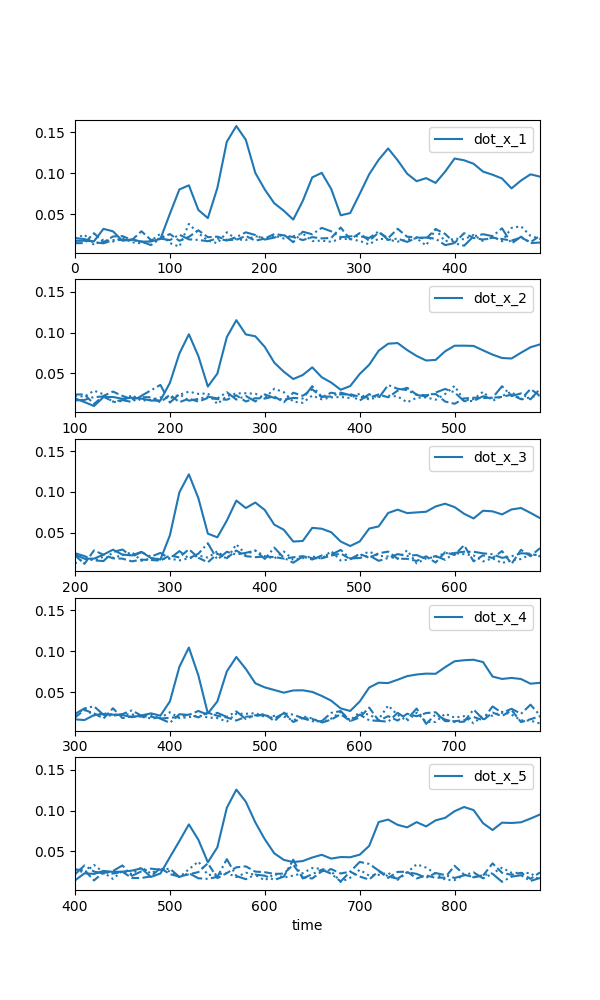

In [96]:
win = [0, (second_level.index.levels[2].max() - (dots.max()-1)*100) / 1000]
r_name = 'dot_x'
measure = 'mean'

regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

fig, axes = plt.subplots(R, 1, sharex=False, sharey=True, figsize=[6, 10])

for r, reg in enumerate(regs):
    times = slice(int(100*r + win[0]*1000), int(100*r + win[1]*1000))
    plot_minmax_regressors(second_level.loc[(slice(None), slice(None), times), :], 
                           [reg], measure, nperm=3, mode='absmax', ax=axes[r])
    axes[r].legend([reg])
    

for a single channel / label

<IPython.core.display.Javascript object>


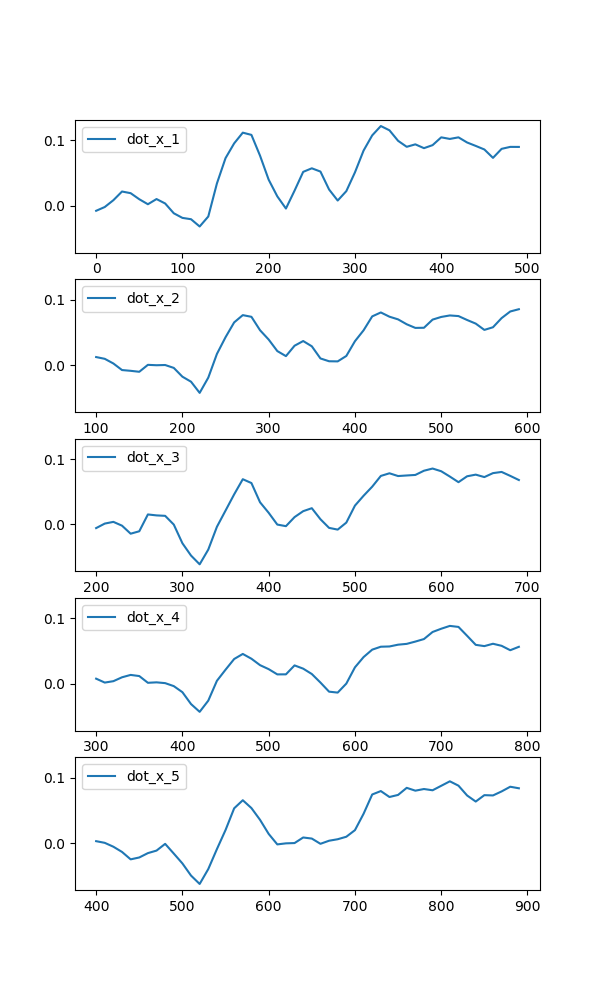

In [99]:
win = [0, (second_level.index.levels[2].max() - (dots.max()-1)*100) / 1000]
r_name = 'dot_x'
measure = 'mean'
label = 'MEG0741'

regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

fig, axes = plt.subplots(R, 1, sharex=False, sharey=True, figsize=[6, 10])

for r, reg in enumerate(regs):
    times = slice(int(100*r + win[0]*1000), int(100*r + win[1]*1000))
    timesa = np.arange(times.start, times.stop+10, 10)
    axes[r].plot(timesa, second_level.loc[(0, label, times), (measure, reg)])
    axes[r].legend([reg])
    

## plot topography of chosen regressor at chosen time point

<IPython.core.display.Javascript object>


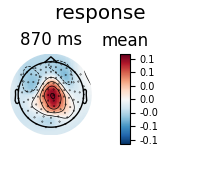

In [95]:
reg = 'response'
measure = 'mean'
time = 0.87

data = second_level.loc[(0, slice(None), time*1000), (measure, reg)]

ev = mne.EvokedArray(data.values[:, None], 
                     evoked.info, tmin=time, 
                     nave=480, comment=reg)

fig = ev.plot_topomap(time, scale=1, vmin=-0.1, vmax=0.1, image_interp='nearest', 
                      title=reg, unit=measure, outlines='skirt');